# Madmom tutorial

This tutorial explains some of the basic design patterns of `madmom`.

Before we start, we have to import some packages:

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

import madmom

/Users/nowahe/mir/test/env/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/Users/nowahe/mir/test/env/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


## Functions / classes

One of the basic design principles of `madmom` is to provide the same functionality both on functions as well as on class level. The classes provide the same functionality but at the next higher abstraction layer. The main differences are:

* functions can return multiple values or a tuple
* classes encapsulate these additional values as attributes
* functions usually operate on and return numpy arrays
* classes are usually subclasses of numpy arrays, i.e. they can be used like numpy arrays
* functions require the input data to be of a specific type
* classes can handle various input types

All these features will be discussed in this tutorial.


## Loading an audio file

Since `madmom` is a library with a strong focus on music information retrival (MIR), let's first load an audio file.
The `load_wave_file` function returns a memory mapped numpy array of the audio file and the sample_rate as an integer value.

In [2]:
signal, sample_rate = madmom.audio.signal.load_wave_file('data/sample.wav')
signal, sample_rate

(memmap([-2494, -2510, -2484, ...,   520,   655,   639], dtype=int16), 44100)

#### Classes provide the same functionality as functions but add some abstraction
A `Signal` object is basically the same as the returned `signal` array but it is enhanced with the the `sample_rate` as an attribute:

In [3]:
sig = madmom.audio.signal.Signal('data/sample.wav')
sig, sig.sample_rate

(Signal([-2494, -2510, -2484, ...,   520,   655,   639], dtype=int16), 44100)

The class uses exactly the same function to load the aufio file, but it encapsulates the sample rate as an attribute of the object. Since the sample rate is important for a lot of consecutive calculations (e.g. to determine the bin frequencies of a STFT) it is necessary to keep it around, but when using the `Signal` class, there is no need to pass it to all the functions which depend on the sample rate of the signal as a seprate variable. The `Signal` class takes care of this automatically (or: the other classes are smart enough to access it correctly).


#### Classes are subclasses of numpy arrays
The `Signal` class is a subclass of a numpy array, i.e. it can be used exactly the same way as any numpy array. 




## Framing an audio signal

We can then split the signal into overlapping frames. Again, there is both a function and a class performing the same task. Since we consider the classes the more convenient way, we use only them in the ongoing. A look into the source code helps you to discover the equivalent function :)

To split the signal into frames of 2048 samples length which overlap by 441 samples, we use the existing `Signal` object as the first argument for instantiation of the `FramedSignal` object.

In [4]:
fs = madmom.audio.signal.FramedSignal(sig, frame_size=2048, hop_size=441)
fs

#### If classes are not subclasses of numpy arrays, they behave similar

The `FramedSignal` is implemented as an indexable/iterable class, so we can access the individual frames exactly like a numpy array, e.g. slice the signal. The only difference is that the index -1 does not refer to the last frame, but to the frame left of the first one.

Note: the reason why the `FramedSignal` is implemented this way and not as a strided view on the signal numpy array is that we also want to be able to use float hop sizes, e.g. to get a constant frame rate. E.g. to get a frame rate of 200, we could either set the `hop_size` to 220.5 samples or simply pass the `fps` argument instead.


In [5]:
fs_200 = madmom.audio.signal.FramedSignal(sig, frame_size=2048, fps=200)
fs_200

In [6]:
fs.frame_rate, fs.hop_size, fs[0]

(100.0,
 441.0,
 Signal([    0,     0,     0, ..., -4553, -4666, -4589], dtype=int16))

In [7]:
fs_200.frame_rate, fs_200.hop_size, fs_200[0]

(200.0,
 220.5,
 Signal([    0,     0,     0, ..., -4553, -4666, -4589], dtype=int16))

The `fps` argument is converted into the appropriate `hop_size`. This conversion could be performed automatically since the `Signal` object has also the needed the sample rate. Thus constant frame rates could be achieved independently of the sample rate of the signal. No need to resample all audio files to the same sample rate beforehand.

#### Automatic object instantiation
Another design feature of the classes is that if they are instantiated with an argument which they don't expect, they try to create an instance of what they expect. E.g. the `FramedSignal` expects a `Signal` instance as the first argument, but we can also pass a file name instead. The `FramedSignal` then instantiates a `Signal` object:

In [8]:
fs_ = madmom.audio.signal.FramedSignal('data/sample.wav')

A reference to the automatically instantiated `Signal` object is kept as the `signal` attribute.

In [9]:
fs_.signal

Signal([-2494, -2510, -2484, ...,   520,   655,   639], dtype=int16)

In [10]:
fs_.frame_rate, fs_.hop_size, fs_[0]

(100.0,
 441.0,
 Signal([    0,     0,     0, ..., -4553, -4666, -4589], dtype=int16))

All three ways of obtaining a `FramedSignal` instance are equivalent.

## Complex STFT

Based on this `FramedSignal` we can now continue to calculate the `STFT` of it. The `STFT` class is (of course) a subclass of a numpy array, i.e. it has a `dtype`, can be sliced, transposed etc..

In [11]:
stft = madmom.audio.stft.STFT(fs)
stft[0:2]

ShortTimeFourierTransform([[-3.15249181 +0.00000000e+00j,  2.62215710 -3.02424717e+00j,
         0.96471846 +5.57876539e+00j, ...,  0.03642104 -3.61841870e-04j,
        -0.03633529 -5.19269597e-05j,  0.03670426 +2.85875227e-04j],
       [-4.28428888 +0.00000000e+00j,  2.02009392 +2.01263618e+00j,
        -1.54068637 -8.30089092e+00j, ...,  0.01295261 -1.75991822e-02j,
        -0.01980834 -9.33106802e-03j, -0.00536164 +2.16161963e-02j]], dtype=complex64)

## Magnitude Spectrogram
More often than the complex `STFT`, the magnitudes of it are used for MIR tasks. Magnitude spectrograms are represented by the `Spectrogram` class.

In [12]:
spec = madmom.audio.spectrogram.Spectrogram(stft)

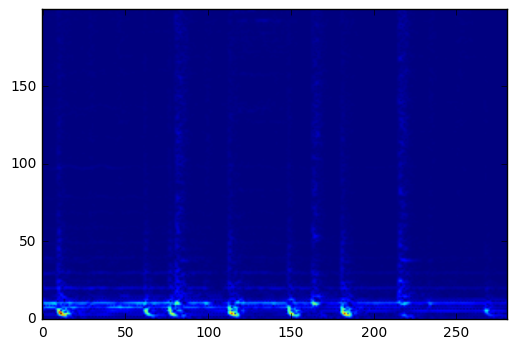

In [13]:
plt.imshow(spec[:, :200].T, aspect='auto', origin='lower')

As before, although the `Spectrogram` class expects a `STFT` instance as its only arument, we could also have passes any other data to it as long as a `STFT` object can be instantiated from it. This can be a `FramedSignal` or `Signal` instance or just a file name (or file handle).

Additional keywords are passed accordingly, i.e. we can get the magnitude spectrogram of a file with a frame size of 2048 samples, a hop size of 200 samples, a FFT size of 4096 samples simple as:

In [14]:
spec = madmom.audio.spectrogram.Spectrogram('data/sample.wav', frame_size=2048, hop_size=200, fft_size=4096)

In [15]:
spec.shape, spec.bin_frequencies

((618, 2048), array([  0.00000000e+00,   1.07666016e+01,   2.15332031e+01, ...,
          2.20177002e+04,   2.20284668e+04,   2.20392334e+04]))

Additionally, the `Spectrogram` class also keeps their underlying objects as attributes, e.g. the factor to which the individual frames overlap, can be accessed as if we go up the instantiation chain.

In [16]:
spec.stft.frames.overlap_factor

0.90234375

For a complete list of attributes and methods of the classes, please refer to the API documentation. These are just the basic things needed to continue with other (higher level) tasks.